In [1]:
# Packages
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import torch
from tqdm import tqdm
import os
from typing import Literal
import gc
import matplotlib.pyplot as plt


In [ ]:
# Load Models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Available Device: {device}")
use_amp = amp_supported = torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (7, 0)
tinyllama_model_name = "TinyLlama/TinyLlama-1.1B-step-50K-105b"
llama7b_model_name = "NousResearch/Llama-2-7b-hf"
# local_model_dir = './model_cache'

# tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
# model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf", torch_dtype=torch.float16).to(device)
# Load model directly

# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-step-50K-105b")
# model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-step-50K-105b",   torch_dtype=torch.float16).to(device)

## Inference: Memory and Max Memory Monitor

In [3]:
# config = AutoConfig.from_pretrained("Tinyllama/Tinyllama-1.1B-step-50K-105b")

# hidden_size = config.hidden_size
# eos_token_id = config.eos_token_id
# max_position_embeddings = config.max_position_embeddings

# print("Hidden Size:", hidden_size)
# print("EOS Token ID:", eos_token_id)
# print("Max Position Embeddings:", max_position_embeddings)

In [4]:
# Hyperparameter
b = 1 # batch size
s = 1 # sequence length
max_s = 4096 # max sequence length

In [ ]:

class ModelMemoryMonitor:
    def __init__(self, model_name, batch_size=1, max_seq_len=4096, torch_dtype=torch.float16, use_amp=False, device="cuda"):
        """
        Initialize the ModelMemoryMonitor for tracking model inference memory usage.

        Args:
            model_name (str): Hugging Face model name or local path.
            batch_size (int): Number of samples in a batch.
            max_seq_len (int): Maximum sequence length.
            torch_dtype (torch.dtype): Data type (e.g., torch.float16).
            use_amp (bool): If True, enables mixed precision inference.
            device (str): Device for inference ('cuda' or 'cpu').
        """
        self.model_name = model_name
        self.torch_dtype = torch_dtype
        self.device = device
        self.use_amp = use_amp
        self.batch_size = batch_size
        self.max_seq_len = max_seq_len
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForCausalLM.from_pretrained(self.model_name, torch_dtype=self.torch_dtype).to(device)

        # Set pad_token to eos_token if no padding token is available
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def reinitialize_model(self):
        """Reinitialize the model (useful for testing or resetting)."""
        self.model = AutoModelForCausalLM.from_pretrained(self.model_name, torch_dtype=self.torch_dtype).to(self.device)

    def delete_model(self):
        """Delete the model and clear the GPU cache."""
        del self.model
        gc.collect()
        torch.cuda.empty_cache()
        print("Model deleted and CUDA cache cleared.")

    def convert_memory(self, memory, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte'):
        """Convert memory to specified unit."""
        if memory_unit == 'mb':
            return memory / 1048576  # Convert bytes to MB
        elif memory_unit == 'gb':
            return memory / 1073741824  # Convert bytes to GB
        return memory  # Default to bytes

    def simulate_input_ids(self, sequence_length: int, only_padding=False):
        """
        Generate dummy input IDs of specified sequence length.

        Args:
            sequence_length (int): Desired sequence length for input IDs.
            only_padding (bool): If True, generates only padding tokens.

        Returns:
            dict: A dictionary with input IDs and attention masks on the specified device.
        """
        dummy_text = "" if only_padding else " ".join(["token"] * int(sequence_length * 1.5))
        inputs = self.tokenizer(dummy_text, return_tensors="pt", padding=True, truncation=True, max_length=self.max_seq_len)
        inputs = {key: value.to(self.device) for key, value in inputs.items()}

        # Validate sequence length and attention mask sum
        actual_length = inputs["input_ids"].shape[1]
        if actual_length != sequence_length:
            print(f"Warning: Expected sequence length ({sequence_length}) does not match actual input length ({actual_length}).")

        attention_mask_sum = inputs["attention_mask"].sum().item()
        if attention_mask_sum != sequence_length:
            print(f"Warning: Attention mask sum ({attention_mask_sum}) does not match expected sequence length ({sequence_length}).")

        return inputs

    def estimate_forward_memory(self, sample_inputs, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte'):
        """
        Estimate memory usage during a forward pass.

        Args:
            sample_inputs (dict): Input data for the model.
            memory_unit (Literal['byte', 'mb', 'gb']): Unit of memory measurement ('byte', 'mb', 'gb').

        Returns:
            tuple: Previous, peak, and current memory in the specified unit.
        """
        self.model.to(self.device)
        self.model.eval()

        # Track initial memory usage
        prev_memory = torch.cuda.memory_allocated(self.device)
        torch.cuda.reset_peak_memory_stats()

        # Perform inference with optional AMP (mixed precision)
        with torch.no_grad():
            if self.use_amp:
                with torch.amp.autocast(device_type=str(self.device)):
                    outputs = self.model(**sample_inputs)
            else:
                outputs = self.model(**sample_inputs)

        # Get peak and current memory usage
        peak_memory = torch.cuda.max_memory_allocated(self.device)
        cur_memory = torch.cuda.memory_allocated(self.device)

        # Convert memory measurements to the specified unit
        prev_memory = self.convert_memory(prev_memory, memory_unit)
        peak_memory = self.convert_memory(peak_memory, memory_unit)
        cur_memory = self.convert_memory(cur_memory, memory_unit)

        # Display memory usage summary
        print(f"Previous Memory: {prev_memory:.2f} {memory_unit.upper()}; Peak Memory: {peak_memory:.2f} {memory_unit.upper()}; Current Memory: {cur_memory:.2f} {memory_unit.upper()}")
        print(f"Peak Memory Difference: {peak_memory - prev_memory:.2f} {memory_unit.upper()}")
        print(f"Total Memory Consumption: {cur_memory - prev_memory:.2f} {memory_unit.upper()}")

        return prev_memory, peak_memory, cur_memory

    def estimate_iterative_inference_memory(self, prompt, max_iters=100):
        """
        Estimate memory usage during iterative token-by-token generation.

        Args:
            prompt (str): Initial prompt for generation.
            max_iters (int): Maximum number of iterations (tokens) to generate.

        Returns:
            tuple: Initial memory, list of peak memory per iteration, list of current memory per iteration.
        """
        self.model.to(self.device)
        self.model.eval()

        prev_memory = torch.cuda.memory_allocated(self.device)
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=self.max_seq_len)
        input_ids = inputs["input_ids"].to(self.device)
        attention_mask = inputs["attention_mask"].to(self.device) 

        peak_memory_lst, cur_memory_lst = [], []

        for i in range(max_iters):
            torch.cuda.reset_peak_memory_stats()

            with torch.no_grad():
                if self.use_amp:
                    with torch.amp.autocast(device_type=str(self.device)):
                        outputs = self.model.generate(
                            input_ids,
                            attention_mask=attention_mask,
                            max_length=input_ids.shape[1] + 1,
                            eos_token_id=self.tokenizer.eos_token_id,
                            pad_token_id=self.tokenizer.eos_token_id,
                            do_sample=False
                        )
                else:
                    outputs = self.model.generate(
                        input_ids,
                        attention_mask=attention_mask,
                        max_length=input_ids.shape[1] + 1,
                        eos_token_id=self.tokenizer.eos_token_id,
                        pad_token_id=self.tokenizer.eos_token_id,
                        do_sample=False
                    )

                next_token_id = outputs[:, -1:]
                input_ids = torch.cat([input_ids, next_token_id], dim=1)

                # Update attention mask to include the new token
                new_attention_mask = torch.ones((attention_mask.shape[0], 1), dtype=attention_mask.dtype, device=self.device)
                attention_mask = torch.cat([attention_mask, new_attention_mask], dim=1)

                if next_token_id.item() == self.tokenizer.eos_token_id:
                    print(f"EOS token generated at iteration {i+1}")
                    break

            peak_memory_lst.append(torch.cuda.max_memory_allocated(self.device))
            cur_memory_lst.append(torch.cuda.memory_allocated(self.device))

        generated_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        print(f'Generated Text: {generated_text}')

        return prev_memory, peak_memory_lst, cur_memory_lst

    def draw_memory_lines(self, prev_memory, peak_memory_lst, cur_memory_lst, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte'):
        """
        Plot memory usage over iterations.

        Args:
            prev_memory (int): Baseline memory usage.
            peak_memory_lst (list[int]): List of peak memory usage per iteration.
            cur_memory_lst (list[int]): List of current memory usage per iteration.
            memory_unit (Literal['byte', 'mb', 'gb']): Unit for memory measurements ('byte', 'mb', 'gb').
        """
        conv_prev_memory = self.convert_memory(prev_memory, memory_unit)
        conv_peak_memory = [self.convert_memory(peak, memory_unit) for peak in peak_memory_lst]
        conv_cur_memory = [self.convert_memory(cur, memory_unit) for cur in cur_memory_lst]

        plt.figure(figsize=(12, 6))
        iterations = range(len(peak_memory_lst))

        # Baseline memory line
        plt.axhline(y=conv_prev_memory, color='gray', linestyle='--', linewidth=1.5, label=f'Baseline ({conv_prev_memory:.2f} {memory_unit.upper()})')

        # Peak and current memory lines
        plt.plot(iterations, conv_peak_memory, label='Peak Memory', color='#FF5733', linewidth=2.5, linestyle='-', marker='o', markersize=5, alpha=0.85)
        plt.plot(iterations, conv_cur_memory, label='Current Memory', color='#3498DB', linewidth=2.5, linestyle='-', marker='x', markersize=5, alpha=0.85)

        # Labels and title
        plt.xlabel("Iterations", fontsize=12)
        plt.ylabel(f"Memory Usage ({memory_unit.upper()})", fontsize=12)
        plt.title("Memory Usage per Iteration", fontsize=16, fontweight='bold')
        plt.legend()
        plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

        plt.tight_layout()
        plt.show()

In [6]:
# # - Test estimate forward memory method
# monitor = ModelMemoryMonitor(model_name, use_amp=use_amp, device=device)
# sample_inputs = monitor.simulate_input_ids(1)
# monitor.estimate_forward_memory(sample_inputs, memory_unit='mb')

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

/home/yuz165/LLM-Simulator/llm-simulator-env/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/yuz165/LLM-Simulator/llm-simulator-env/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated Text: The TinyLlama project aims to pretrain 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


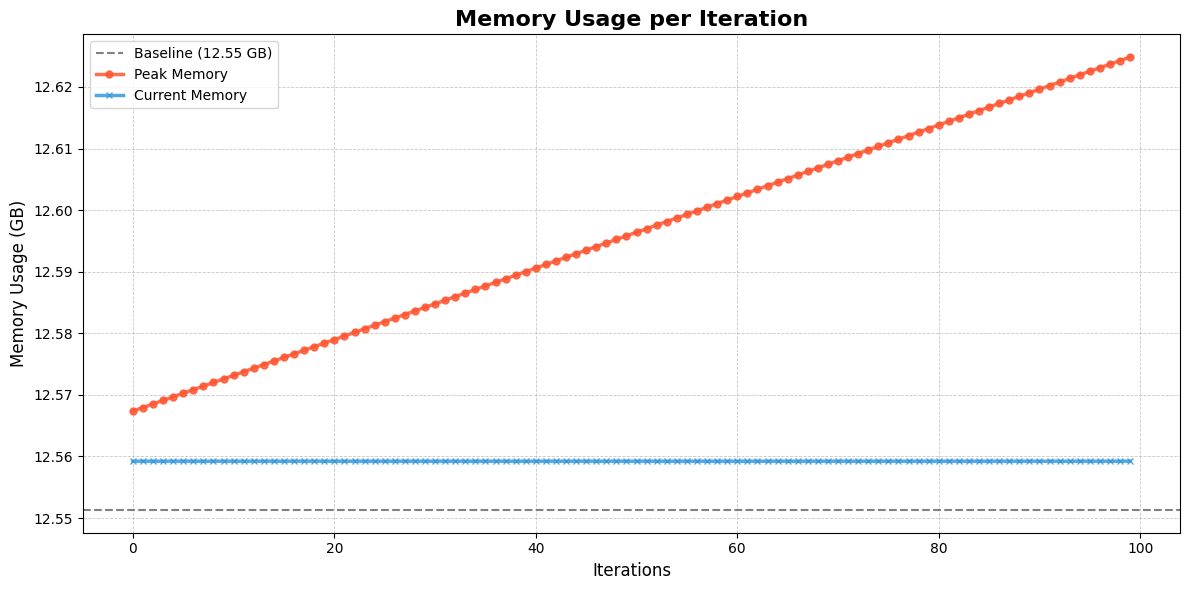

In [7]:
# Test estimate inference memory method
prompt = (
    'You should generate 100 words to explain diffusion model: '
)
monitor = ModelMemoryMonitor(llama7b_model_name, use_amp=use_amp, device=device)
prev_memory, peak_memory_lst, cur_memory_lst = monitor.estimate_iterative_inference_memory(prompt)
monitor.draw_memory_lines(prev_memory, peak_memory_lst, cur_memory_lst, memory_unit='gb')